# Crevasse model with a single parameter set
This note book looks in detail at individual solutions.  Another notebook looks at ensembles of solutions over different parts of the parameter space.

In [9]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [10]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib notebook
from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path

import crevasse as c # main module for this project
from importlib import reload
reload(c)

<module 'crevasse' from '/home/bradlipovsky/notebooks/Near-Front-Crevasses/crevasse.py'>

## Define baseline parameters

In [11]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

## Define the FEM solution

In [12]:
# U = elasticity_solutions('uniform-end-load', W, H,  E, nu)
# U = elasticity_solutions('gravity-only', W, H,  E, nu)
# U = elasticity_solutions('gravity-free-front', W, H,  E, nu)
# U = elasticity_solutions('gravity-bottom-pressure', W, H, E, nu)
# U = elasticity_solutions('wrong-bottom-bc', W, H, E, nu)
# U = elasticity_solutions('full', W, H, E, nu)
# U,mesh = elasticity_solutions('wrong-bottom-minus-prestress', W, H, E, nu)
# U,mesh = elasticity_solutions('uniform-end-load-prestress', W, H, E, nu)

U,mesh = c.elasticity_solutions(case='full-minus-prestress',verbose=True,crevasse_location="surface",
                             geometry=geom,swell_amplitude=0.0, swell_phase=0.0)

---- full-minus-prestress -----
Vertical deflection:
    Numerical:  -0.117260
Horizontal deflection:
    Numerical:  -0.816103
 


## Plot the mesh

<IPython.core.display.Javascript object>


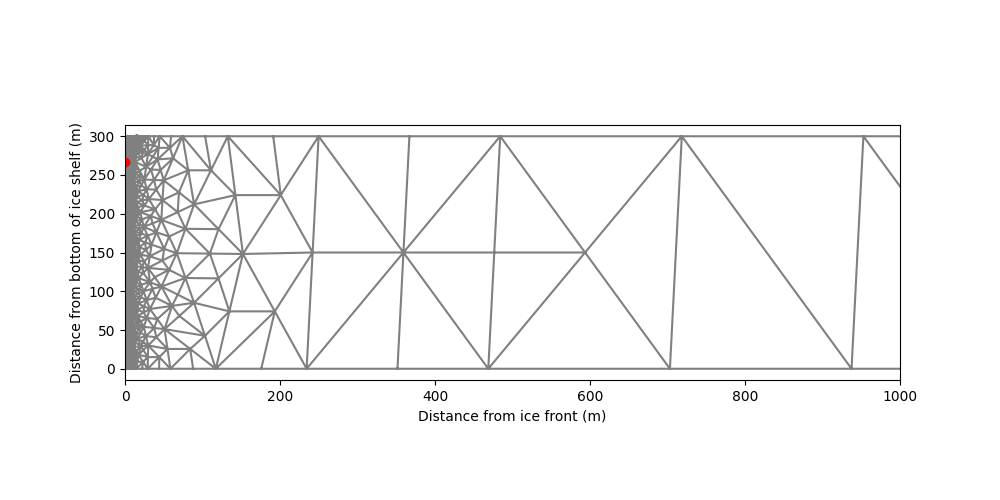

In [16]:
Hw = mats['rho']/mats['rhow']*geom['H']
fig,ax=plt.subplots(figsize=(10,5))
plot(mesh)
ax.set_xlim([0,1e3])
# ax.set_ylim([Hw-2,Hw+2])
plt.plot(0,Hw,'or')
plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.show()

<IPython.core.display.Javascript object>


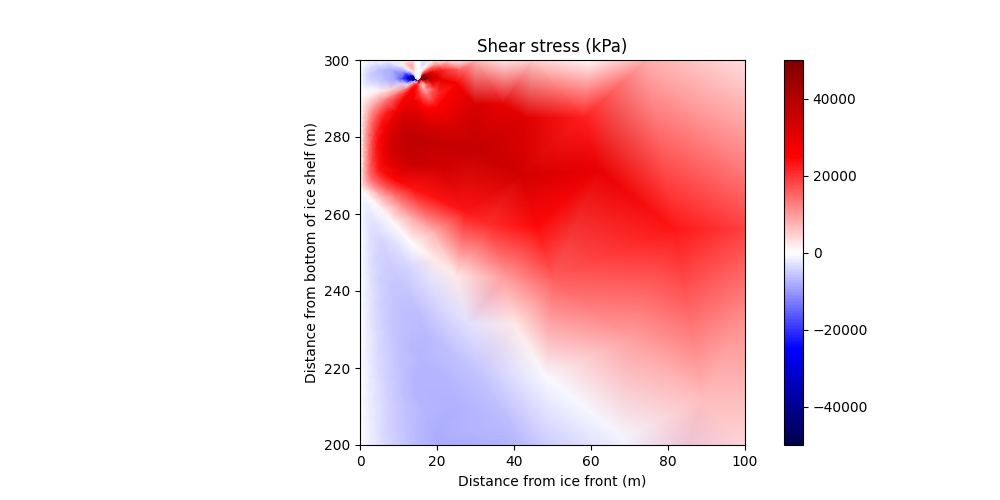

In [17]:
# slic = []
# Nx = 100
# xr = np.linspace(0,geom['W'],Nx)


# fig=plt.subplots()

# for x in xr:
#     slic.append( U( x, geom['H'])[1] )

# ax = plt.subplot(2,1,1)     
# # ax.patch.set_facecolor('xkcd:mint green')
# ax.plot(xr,slic)
# ax.set_ylabel('Vertical displacement')
# # plt.ylim((-0.8,0.2))

# slic = []
# for x in xr:
#     slic.append( U( x, geom['H'])[0] )
# ax = plt.subplot(2,1,2)      
# ax.plot(xr,slic)
# ax.set_ylabel('Horizontal displacement')
# #     c=plot(u[0],mode='color',vmin=0)
# #     plt.colorbar(c)
# plt.grid()
# #     plt.legend()
# plt.show()

mats['mu'] = mats['E']/2./(1+mats['nu'])
mats['lmbda'] = mats['E']*mats['nu']/(1+mats['nu'])/(1-2*mats['nu'])

fig,ax=plt.subplots(figsize=(10,5))
# c=plot(sigma(U,mats['lmbda'],mats['mu'])[0,0],mode='color',vmin=00e3,vmax=300e3,cmap='viridis')
# c=plot(sigma(U)[0,1],mode='color',cmap='viridis',vmax=1e6,vmin=-1e6)
c=plot(c.sigma(U,mats['lmbda'],mats['mu'])[0,1],mode='color',cmap='seismic',vmin=-50e3,vmax=50e3)
# c=plot(U[0],mode='color',vmin=-10,vmax=10,cmap='seismic')

ax.set_xlim([0,100])
ax.set_ylim([200,300])
plt.show()


# plt.ylim([0,H])

# plt.xlim([geom['Lc']-2*geom['Hc'],geom['Lc']+2*geom['Hc']])
# plt.ylim([geom['H']-geom['Hc']*4,geom['H']])

plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.title('Shear stress (kPa)')
plt.colorbar(c)

# fig,ax=plt.subplots()
# plot(mesh)
# ax.set_xlim((0,1000))
# plt.show()

# Analytical solutions

In [7]:
Lcs = np.logspace(np.log10(5),np.log10(50e3),50)
r = mats['rho']/mats['rhow']

D = mats['E']/(1-mats['nu']**2) * geom['H']**3 / 12
flexural_gravity_wavelength = 2*pi*(D/(mats['rhow']*mats['g']))**(1/4)


# Surface Crevasse
def f(y):
    gamma = y/geom['Hc']
    lambd = geom['Hc']/geom['H']
    val =  3.52*(1-gamma)/(1-lambd)**(3/2)
    val += - (4.35-5.28*gamma)/(1-lambd)**(1/2)
    val += ( (1.30 - 0.3*gamma**(3/2)) / (1-gamma**2)**(1/2) + 0.83 - 1.76*gamma) * (1 - (1-gamma)*lambd)
    return val
dK = integrate.quad(f, 0, geom['Hc'])
K_crack_face_loading_surface = 2*mats['rho']*mats['g']/np.sqrt(np.pi*geom['Hc']) * dK[0]

sig0 = mats['rho']*mats['g']*geom['H'] / 2 *(1-mats['rho']/mats['rhow'])
KI_analytical = 1.12 * sig0 * sqrt(np.pi * geom['Hc'])
KI_analytical += K_crack_face_loading_surface

lam = (4*D/(mats['rhow']*mats['g']))**(1/4)
m0 = mats['rho']*mats['g']*geom['H']**3 / 12 * (3*r - 2*r**2 - 1)
II = geom['H']**3 / 12
M_flex = m0 * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) + np.sin(Lcs/lam))
sig_flex = M_flex * geom['H']/2 / II 
KI_analytical_bending = KI_analytical/1e6 + 1.12 * (sig_flex) * sqrt(np.pi * geom['Hc']) / 1e6



# Bottom Crevasse
def f_bot(y):
    Hw = mats['rho']/mats['rhow'] * geom['H']
    sig = lambda y: mats['rhow']*mats['g']*(Hw-y) - mats['rho']*mats['g']*(geom['H']-y)
    gamma = y/geom['Hc']
    lambd = geom['Hc']/geom['H']
    kernel =  3.52*(1-gamma)/(1-lambd)**(3/2)
    kernel += - (4.35-5.28*gamma)/(1-lambd)**(1/2)
    kernel += ( (1.30 - 0.3*gamma**(3/2)) / (1-gamma**2)**(1/2) + 0.83 - 1.76*gamma) * (1 - (1-gamma)*lambd)
    val = sig(y) * kernel
    return val
dK_bot = integrate.quad(f_bot, 0, geom['Hc'])
K_crack_face_loading_bottom  =  2/np.sqrt(np.pi*geom['Hc']) * dK_bot[0]
KI_analytical_bottom = KI_analytical - K_crack_face_loading_surface
KI_analytical_bending_bottom = KI_analytical_bottom/1e6 - 1.12 * (sig_flex) * sqrt(np.pi * geom['Hc']) / 1e6

# Test the beam solution

<IPython.core.display.Javascript object>


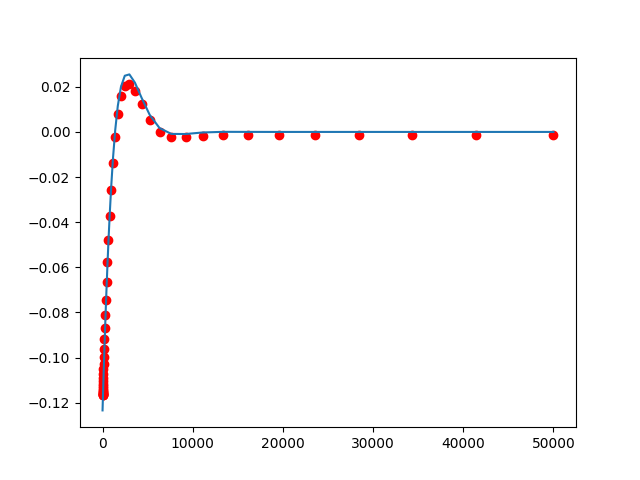

In [27]:
r = mats['rho']/mats['rhow']
# lam = flexural_gravity_wavelength
lam = (4*D/(mats['rhow']*mats['g']))**(1/4)
m0 = mats['rho']*mats['g']*geom['H']**3 / 12 * (3*r - 2*r**2 - 1)
II = geom['H']**3 / 12
M_flex = m0 * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) + np.sin(Lcs/lam))
sig_flex = M_flex * geom['H']/2 / II 
w_flex =  - 2 * m0 / lam**2 / mats['rho'] / mats['g'] * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) - np.sin(Lcs/lam))

mu = mats['E']/2./(1+mats['nu'])
lmbda = mats['E']*mats['nu']/(1+mats['nu'])/(1-2*mats['nu'])

fig=plt.subplots()
for x in Lcs:
    plt.plot(x,U((x,geom['H']*.9))[1],'or')
plt.plot(Lcs,w_flex)
